# Annotation 검수 노트북

이미지 파일명을 입력하면 해당 `annotations.json`을 자동으로 찾아 라벨링 결과를 시각화합니다.

**탐색 범위**: `data/`, `data_augmented/` 전체 (category × split 자동 탐색)

In [5]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection
from pathlib import Path
from PIL import Image

# ── 프로젝트 루트 ──────────────────────────────────────────────
BASE_DIR = Path('/home/jjh0709/gitrepo/VISION-Instance-Seg')

# 탐색할 모든 (category, split) 경로
SEARCH_ROOTS = [
    BASE_DIR / 'data'          / 'Cable'   / 'train',
    BASE_DIR / 'data'          / 'Cable'   / 'val',
    BASE_DIR / 'data'          / 'Screw'   / 'train',
    BASE_DIR / 'data'          / 'Casting' / 'train',
    BASE_DIR / 'data_augmented' / 'Cable'   / 'gen_ai',
    BASE_DIR / 'data_augmented' / 'Cable'   / 'traditional_aug',
    BASE_DIR / 'data_augmented' / 'Screw'   / 'gen_ai',
    BASE_DIR / 'data_augmented' / 'Screw'   / 'traditional_aug',
    BASE_DIR / 'data_augmented' / 'Casting' / 'gen_ai',
    BASE_DIR / 'data_augmented' / 'Casting' / 'traditional_aug',
]

# 카테고리 ID → 색상
CLASS_COLORS = {
    0: '#ff4444',   # defect / Inclusoes
    1: '#44aaff',   # thunderbolt / Rechupe
    2: '#44ff88',
    3: '#ffaa00',
}

print('설정 완료.')

설정 완료.


In [6]:
# ================================================================
# ★ 여기에 검수할 이미지 파일명 입력
# ================================================================
IMAGE_FILENAME = 'Screw_000000.jpg'

In [7]:
def find_image_and_annotations(filename):
    """파일명으로 이미지 경로 + annotations.json 경로 자동 탐색"""
    for root in SEARCH_ROOTS:
        if not root.exists():
            continue

        ann_path = root / 'annotations.json'
        img_in_subdir = root / 'images' / filename
        img_flat      = root / filename

        img_path = img_in_subdir if img_in_subdir.exists() else (img_flat if img_flat.exists() else None)

        if img_path is None or not ann_path.exists():
            continue

        with open(ann_path, 'r') as f:
            data = json.load(f)

        img_entry = next((i for i in data['images'] if i['file_name'] == filename), None)
        if img_entry is None:
            # annotations.json에 등록은 안 됐지만 이미지 파일은 있는 경우
            return img_path, ann_path, data, None, []

        anns = [a for a in data['annotations'] if a['image_id'] == img_entry['id']]
        return img_path, ann_path, data, img_entry, anns

    return None, None, None, None, []


# 탐색 실행
img_path, ann_path, coco_data, img_entry, anns = find_image_and_annotations(IMAGE_FILENAME)

if img_path is None:
    print(f'[ERROR] "{IMAGE_FILENAME}" 을 찾을 수 없습니다.')
    print('탐색 경로:')
    for r in SEARCH_ROOTS:
        print(f'  {r}')
else:
    print(f'이미지   : {img_path}')
    print(f'JSON     : {ann_path}')
    if img_entry:
        print(f'크기     : {img_entry["width"]} × {img_entry["height"]}')
        print(f'Annotation 수: {len(anns)}개')

        # 카테고리 ID → 이름 매핑
        cat_map = {c['id']: c['name'] for c in coco_data.get('categories', [])}
        for a in anns:
            cname = cat_map.get(a['category_id'], f"id={a['category_id']}")
            seg_count = len(a.get('segmentation', []))
            print(f'  └ ann_id={a["id"]} | class={cname} | bbox={a["bbox"]} | seg_polygons={seg_count}')
    else:
        print('  ※ 이미지 파일은 있지만 annotations.json에 등록되지 않음 (미라벨)')

이미지   : /home/jjh0709/gitrepo/VISION-Instance-Seg/data_augmented/Screw/gen_ai/images/Screw_000000.jpg
JSON     : /home/jjh0709/gitrepo/VISION-Instance-Seg/data_augmented/Screw/gen_ai/annotations.json
크기     : 864 × 1184
Annotation 수: 1개
  └ ann_id=1 | class=defect | bbox=[398, 465, 84, 111] | seg_polygons=5


/tmp/ipykernel_36367/4109007383.py:52: UserWarning: Glyph 44060 (\N{HANGUL SYLLABLE GAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


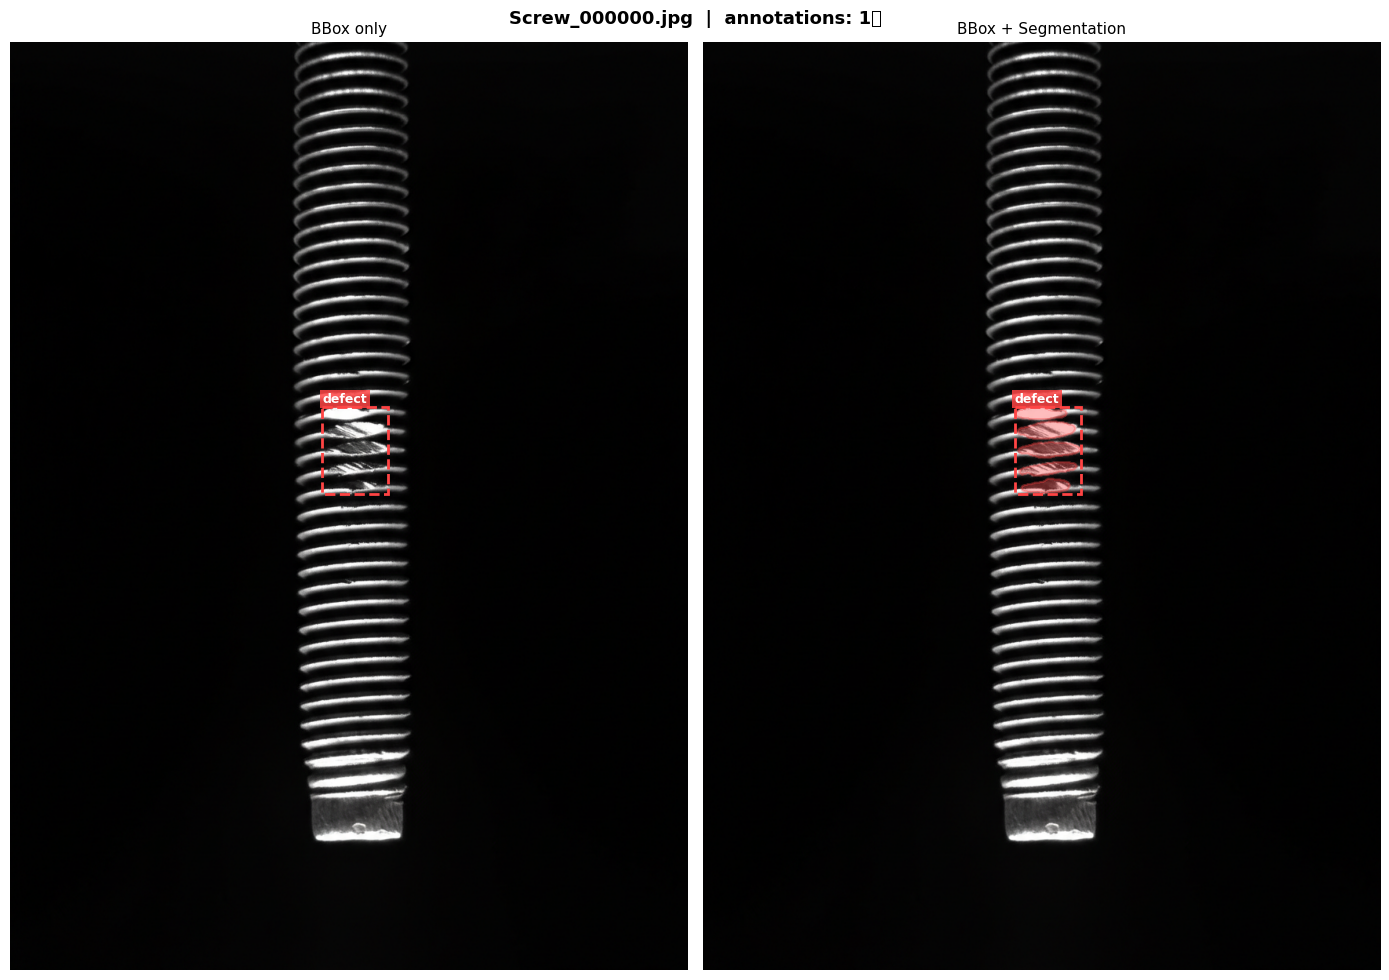

In [8]:
def visualize_annotation(img_path, anns, coco_data, figsize=(14, 10)):
    """이미지 위에 BBox + Segmentation 오버레이"""
    if img_path is None:
        print('이미지 없음')
        return

    image = np.array(Image.open(img_path).convert('RGB'))
    cat_map = {c['id']: c['name'] for c in coco_data.get('categories', [])}

    fig, axes = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(f'{img_path.name}  |  annotations: {len(anns)}개', fontsize=13, fontweight='bold')

    for ax, show_seg in zip(axes, [False, True]):
        ax.imshow(image)
        ax.set_title('BBox only' if not show_seg else 'BBox + Segmentation', fontsize=11)
        ax.axis('off')

        if not anns:
            ax.text(image.shape[1]//2, image.shape[0]//2,
                    'No Annotations',
                    ha='center', va='center', fontsize=16,
                    color='white', bbox=dict(facecolor='red', alpha=0.7))
            continue

        for ann in anns:
            cat_id   = ann['category_id']
            cat_name = cat_map.get(cat_id, f'id={cat_id}')
            color    = CLASS_COLORS.get(cat_id, '#ffffff')
            x, y, w, h = ann['bbox']

            # BBox
            rect = patches.Rectangle(
                (x, y), w, h,
                linewidth=2, edgecolor=color, facecolor='none', linestyle='--'
            )
            ax.add_patch(rect)
            ax.text(x, y - 5, cat_name,
                    fontsize=9, color='white', fontweight='bold',
                    bbox=dict(facecolor=color, alpha=0.85, pad=2, linewidth=0))

            # Segmentation
            if show_seg and ann.get('segmentation'):
                for poly_pts in ann['segmentation']:
                    if len(poly_pts) < 6:
                        continue
                    pts = np.array(poly_pts).reshape(-1, 2)
                    polygon = MplPolygon(pts, closed=True,
                                        facecolor=color, alpha=0.35,
                                        edgecolor=color, linewidth=1.5)
                    ax.add_patch(polygon)

    plt.tight_layout()
    plt.show()


# 시각화 실행
if img_path:
    visualize_annotation(img_path, anns, coco_data)

In [ ]:
# ================================================================
# 카테고리 전체 통계 보기
# ================================================================
def show_dataset_stats():
    print('=' * 60)
    print('데이터셋 전체 통계')
    print('=' * 60)
    for root in SEARCH_ROOTS:
        ann_path = root / 'annotations.json'
        img_dir  = root / 'images' if (root / 'images').exists() else root
        n_files  = len([f for f in img_dir.iterdir() if f.suffix.lower() in {'.jpg','.jpeg','.png'}]) if img_dir.exists() else 0

        if not ann_path.exists():
            label = str(root.relative_to(BASE_DIR))
            print(f'  {label:<40} images={n_files:>4}  ann=없음')
            continue

        with open(ann_path) as f:
            d = json.load(f)
        cat_map   = {c['id']: c['name'] for c in d.get('categories', [])}
        by_class  = {}
        for a in d['annotations']:
            name = cat_map.get(a['category_id'], f"id={a['category_id']}")
            by_class[name] = by_class.get(name, 0) + 1

        label = str(root.relative_to(BASE_DIR))
        print(f'  {label:<40} images={n_files:>4}  anns={len(d["annotations"]):>4}  {by_class}')

show_dataset_stats()